In [4]:
from imgnetdatastuff import dataset_imagenetvalpart
from torchvision import transforms, models
from guidedbpcodehelpers import imshow2,setbyname
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import os

In [2]:
transform = transforms.Compose([transforms.Resize(256), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_set = dataset_imagenetvalpart("./imagespart/","./val/","./synset_words.txt",250,transform=transform)
dataloader = DataLoader(val_set, batch_size=1,shuffle=True, num_workers=0)

./imagespart/ILSVRC2012_val_00000001.JPEG
./imagespart/ILSVRC2012_val_00000002.JPEG
./imagespart/ILSVRC2012_val_00000003.JPEG
./imagespart/ILSVRC2012_val_00000004.JPEG
./imagespart/ILSVRC2012_val_00000005.JPEG
./imagespart/ILSVRC2012_val_00000006.JPEG
./imagespart/ILSVRC2012_val_00000007.JPEG
./imagespart/ILSVRC2012_val_00000008.JPEG
./imagespart/ILSVRC2012_val_00000009.JPEG
./imagespart/ILSVRC2012_val_00000010.JPEG
./imagespart/ILSVRC2012_val_00000011.JPEG
./imagespart/ILSVRC2012_val_00000012.JPEG
./imagespart/ILSVRC2012_val_00000013.JPEG
./imagespart/ILSVRC2012_val_00000014.JPEG
./imagespart/ILSVRC2012_val_00000015.JPEG
./imagespart/ILSVRC2012_val_00000016.JPEG
./imagespart/ILSVRC2012_val_00000017.JPEG
./imagespart/ILSVRC2012_val_00000018.JPEG
./imagespart/ILSVRC2012_val_00000019.JPEG
./imagespart/ILSVRC2012_val_00000020.JPEG
./imagespart/ILSVRC2012_val_00000021.JPEG
./imagespart/ILSVRC2012_val_00000022.JPEG
./imagespart/ILSVRC2012_val_00000023.JPEG
./imagespart/ILSVRC2012_val_000000

In [3]:
##########
# PART 1 #
##########
vgg16 = models.vgg16(pretrained=True)
vgg16_bn = models.vgg16_bn(pretrained=True)

def hook_fn(m, i, o):
    mod1 = m.in_channels==3 and m.out_channels==64  # conv module closest to input
    mod2 = m.in_channels==64 and m.out_channels==64 # conv module 2nd closest to input
    if mod1:
        end = "_1"
    elif mod2:
        end = "_2"
    if mod1 or mod2:  # 2 conv modules closest to the input
        global inp
        filename = inp['filename'][0].split("/")[-1][:-5]
        for grad in o:
            try:
                l2_norm = torch.sqrt(torch.sum(grad[0]**2))   # output[0]
                torch.save(l2_norm, './vgg16/'+filename+end)
            except AttributeError: 
                print ("None found for Gradient")

def hook_fn_bn(m, i, o):
    mod1 = m.in_channels==3 and m.out_channels==64  # conv module closest to input
    mod2 = m.in_channels==64 and m.out_channels==64 # conv module 2nd closest to input
    if mod1:
        end = "_1"
    elif mod2:
        end = "_2"
    if mod1 or mod2:  # 2 conv modules closest to the input
        global inp
        filename = inp['filename'][0].split("/")[-1][:-5]
        for grad in o:
            try:
                l2_norm = torch.sqrt(torch.sum(grad[0]**2))   # sum across all channels and dimensions
                torch.save(l2_norm, './vgg16_bn/'+filename+end)
            except AttributeError: 
                print ("None found for Gradient")

for module in vgg16.modules():
    if isinstance(module,nn.Conv2d):   # only get the gradients of conv modules
        module.register_backward_hook(hook_fn)

for module in vgg16_bn.modules():
    if isinstance(module,nn.Conv2d):   # only get the gradients of conv modules
        module.register_backward_hook(hook_fn_bn)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16_bn.to(device)
        
for i,inp in enumerate(tqdm(dataloader)):
    img = inp['image'].to(device)
    label = inp['label'].to(device)
    out = vgg16(img)
    out_bn = vgg16_bn(img)
    
    criterion = nn.CrossEntropyLoss()
    
    loss = criterion(out, label)
    loss.backward()
    
    loss_bn = criterion(out_bn, label)
    loss_bn.backward()

100%|██████████| 250/250 [00:25<00:00,  9.77it/s]


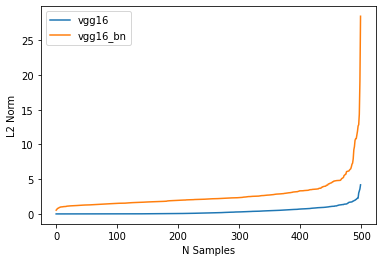

In [21]:
l2_ls = list()
l2_bn_ls = list()

for filename in os.listdir("./vgg16/"):
    l2_ls.append(torch.load("./vgg16/"+filename).item())

for filename in os.listdir("./vgg16_bn/"):
    l2_bn_ls.append(torch.load("./vgg16_bn/"+filename).item())

plt.plot(range(0,len(l2_ls)),sorted(l2_ls),label='vgg16')
plt.plot(range(0,len(l2_bn_ls)),sorted(l2_bn_ls),label='vgg16_bn')
plt.legend()
plt.xlabel('N Samples')
plt.ylabel('L2 Norm')
plt.show()

components ['features', '1']
components ['1']
components ['features', '3']
components ['3']
components ['features', '6']
components ['6']
components ['features', '8']
components ['8']
components ['features', '11']
components ['11']
components ['features', '13']
components ['13']
components ['features', '15']
components ['15']
components ['features', '18']
components ['18']
components ['features', '20']
components ['20']
components ['features', '22']
components ['22']
components ['features', '25']
components ['25']
components ['features', '27']
components ['27']
components ['features', '29']
components ['29']
components ['classifier', '1']
components ['1']
components ['classifier', '4']
components ['4']
torch.Size([3, 224, 224])


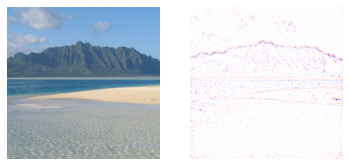

In [20]:
##########
# PART 2 #
##########

class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0        # if input is negative
        grad_input[grad_input < 0] = 0   # if gradient itself is negative
        return grad_input

class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()
    
    def forward(self,input):
        return MyReLU.apply(input)

    
vgg16 = models.vgg16(pretrained=True)

for name,module in vgg16.named_modules():
    if isinstance(module,nn.ReLU):  # if module is relu, change to our custom relu
        setbyname(vgg16,name,ReLU())
        
inp = next(iter(dataloader))
img = inp['image']
img.requires_grad=True
out = vgg16(img)

criterion = nn.CrossEntropyLoss()
loss = criterion(out, inp['label'])
loss.backward()
imshow2(img.grad,img)